# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period.
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model.
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

Se toman los daily (en nuestro caso weekly) coeficientes de información, como el mejor indicador y no los totales.

## Imports & Settings

In [110]:
import warnings

warnings.filterwarnings("ignore")

In [111]:
%matplotlib inline

import os
import sys
import warnings
from io import StringIO
from pathlib import Path
from time import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from alphalens import performance as perf
from alphalens import plotting
from alphalens.tears import create_full_tear_sheet, create_summary_tear_sheet
from alphalens.utils import (
    get_clean_factor_and_forward_returns,
    rate_of_return,
    std_conversion,
)
from scipy.stats import pearsonr, spearmanr

In [112]:
sys.path.insert(1, os.path.join(sys.path[0], ".."))
from utils import MultipleTimeSeriesCV

In [113]:
sns.set_style("whitegrid")

In [114]:
# YEAR = 252
# YEAR = 12
idx = pd.IndexSlice

In [115]:
scope_params = ["lookahead", "train_length", "test_length"]
daily_ic_metrics = [
    "daily_ic_mean",
    "daily_ic_mean_n",
    "daily_ic_median",
    "daily_ic_median_n",
]
lgb_train_params = [
    "learning_rate",
    "num_leaves",
    "feature_fraction",
    "min_data_in_leaf",
]
rf_train_params = [
    "bagging_fraction",
    "feature_fraction",
    "min_data_in_leaf",
    "max_depth",
]
catboost_train_params = ["max_depth", "min_child_samples"]

In [116]:
results_path = Path("results", "us_stocks")
if not results_path.exists():
    results_path.mkdir(parents=True)

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [121]:
with pd.HDFStore(results_path / "tuning_lgb.h5") as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith("metrics")]
    ):
        _, t, train_length, test_length = key.split("/")[:4]
        attrs = {
            "lookahead": t,
            "train_length": train_length,
            "test_length": test_length,
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = (
    pd.melt(
        # lgb_metrics.T.drop("t", axis=1),
        lgb_metrics.T,
        id_vars=id_vars,
        value_name="ic",
        var_name="boost_rounds",
    )
    .dropna()
    .apply(pd.to_numeric)
)

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['lookahead', 'train_length', 'test_length', 'learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf', 'daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']"

KeyError: "['t'] not found in axis"

In [118]:
lgb_metrics.head()

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
0,1,52,12,0.3,8.0,0.95,100.0,0.023270,50.0,0.033333,50.0,50,0.001789
1,1,52,12,0.3,8.0,0.60,200.0,0.002203,100.0,-0.008368,50.0,50,-0.024741
2,1,52,12,0.3,8.0,0.60,50.0,0.020486,100.0,0.025000,100.0,50,0.010307
3,1,52,12,0.3,8.0,0.30,100.0,0.020233,50.0,0.033333,50.0,50,-0.009735
4,1,52,12,0.3,8.0,0.30,200.0,0.002325,50.0,0.008386,50.0,50,-0.018173


In [ ]:
# print(os.getcwd())

In [ ]:
lgb_metrics.to_hdf("data/model_tuning.h5", "lgb/metrics")
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          432 non-null    int64  
 1   train_length       432 non-null    int64  
 2   test_length        432 non-null    int64  
 3   learning_rate      432 non-null    float64
 4   num_leaves         432 non-null    float64
 5   feature_fraction   432 non-null    float64
 6   min_data_in_leaf   432 non-null    float64
 7   daily_ic_mean      432 non-null    float64
 8   daily_ic_mean_n    432 non-null    float64
 9   daily_ic_median    432 non-null    float64
 10  daily_ic_median_n  432 non-null    float64
 11  boost_rounds       432 non-null    int64  
 12  ic                 432 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 44.0 KB


In [ ]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          52            1              108
                         12             108
           216           1              108
                         12             108
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [ ]:
int_cols = ["lookahead", "train_length", "test_length", "boost_rounds"]

In [ ]:
lgb_ic = []
with pd.HDFStore(results_path / "tuning_lgb.h5") as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split("/")[:4]
        if key.startswith("daily_ic"):
            df = (
                store[key]
                .drop(["boosting", "objective", "verbose"], axis=1)
                .assign(lookahead=t, train_length=train_length, test_length=test_length)
            )
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [ ]:
lgb_ic

,date,50,100,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,lookahead,train_length,test_length
0,2007-01-21,-0.583333,-0.600000,0.30,8,0.95,100,1,52,12
1,2007-01-28,0.033333,0.200000,0.30,8,0.95,100,1,52,12
2,2007-02-04,-0.283333,-0.050000,0.30,8,0.95,100,1,52,12
3,2007-02-11,-0.200000,0.066667,0.30,8,0.95,100,1,52,12
4,2007-02-18,0.166667,0.000000,0.30,8,0.95,100,1,52,12
...,...,...,...,...,...,...,...,...,...,...
134779,2018-12-02,-0.167365,-0.033333,0.01,128,0.30,50,1,216,1
134780,2018-12-09,-0.451887,-0.550000,0.01,128,0.30,50,1,216,1
134781,2018-12-16,-0.150629,-0.116667,0.01,128,0.30,50,1,216,1
134782,2018-12-23,-0.111803,-0.084037,0.01,128,0.30,50,1,216,1


In [ ]:
id_vars = ["date"] + scope_params + lgb_train_params
lgb_ic = pd.melt(
    lgb_ic, id_vars=id_vars, value_name="ic", var_name="boost_rounds"
).dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [ ]:
lgb_ic.to_hdf("data/model_tuning.h5", "lgb/ic")
lgb_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250749 entries, 0 to 269567
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              250749 non-null  datetime64[ns]
 1   lookahead         250749 non-null  object        
 2   train_length      250749 non-null  object        
 3   test_length       250749 non-null  object        
 4   learning_rate     250749 non-null  float64       
 5   num_leaves        250749 non-null  int64         
 6   feature_fraction  250749 non-null  float64       
 7   min_data_in_leaf  250749 non-null  int64         
 8   boost_rounds      250749 non-null  object        
 9   ic                250749 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 21.0+ MB


In [ ]:
lgb_daily_ic = (
    lgb_ic.groupby(id_vars[1:] + ["boost_rounds"])
    .ic.mean()
    .to_frame("ic")
    .reset_index()
)
lgb_daily_ic.to_hdf("data/model_tuning.h5", "lgb/daily_ic")
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         432 non-null    int64  
 1   train_length      432 non-null    int64  
 2   test_length       432 non-null    int64  
 3   learning_rate     432 non-null    float64
 4   num_leaves        432 non-null    int64  
 5   feature_fraction  432 non-null    float64
 6   min_data_in_leaf  432 non-null    int64  
 7   boost_rounds      432 non-null    int64  
 8   ic                432 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 30.5 KB


In [ ]:
lgb_ic = pd.read_hdf("data/model_tuning.h5", "lgb/ic")
lgb_daily_ic = pd.read_hdf("data/model_tuning.h5", "lgb/daily_ic")

### Random Forest

We proceed similarly for Random forest

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [ ]:
with pd.HDFStore(results_path / "tuning_rf.h5") as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith("metrics")]
    ):
        _, t, train_length, test_length = key.split("/")[:4]
        attrs = {
            "lookahead": t,
            "train_length": train_length,
            "test_length": test_length,
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            rf_metrics = pd.Series(s).to_frame(i)
        else:
            rf_metrics[i] = pd.Series(s)

id_vars = scope_params + rf_train_params + daily_ic_metrics
rf_metrics = (
    pd.melt(
        rf_metrics.T.drop("t", axis=1),
        id_vars=id_vars,
        value_name="ic",
        var_name="boost_rounds",
    )
    .dropna()
    .apply(pd.to_numeric)
)

In [ ]:
# print(os.getcwd())

In [ ]:
id_vars

['lookahead',
 'train_length',
 'test_length',
 'bagging_fraction',
 'feature_fraction',
 'min_data_in_leaf',
 'max_depth',
 'daily_ic_mean',
 'daily_ic_mean_n',
 'daily_ic_median',
 'daily_ic_median_n']

In [ ]:
import pandas as pd

# Abre el archivo HDF5
store = pd.HDFStore(results_path / "tuning_rf.h5")

# Imprime las claves
for key in store.keys():
    print(key)

# No olvides cerrar el archivo HDF5 cuando hayas terminado
store.close()

/predictions/1/52/12/0.95/0.95/89/10
/predictions/1/52/12/0.95/0.95/89/5
/predictions/1/52/12/0.95/0.95/100/-1
/predictions/1/52/12/0.95/0.95/100/5
/predictions/1/52/12/0.95/0.75/89/10
/predictions/1/52/12/0.95/0.75/89/5
/predictions/1/52/12/0.95/0.75/200/-1
/predictions/1/52/12/0.95/0.75/100/10
/predictions/1/52/12/0.95/0.75/100/5
/predictions/1/52/12/0.75/0.95/89/-1
/predictions/1/52/12/0.75/0.95/200/10
/predictions/1/52/12/0.75/0.95/200/5
/predictions/1/52/12/0.75/0.95/100/-1
/predictions/1/52/12/0.75/0.95/100/10
/predictions/1/52/12/0.75/0.75/89/10
/predictions/1/52/12/0.75/0.75/89/5
/predictions/1/52/12/0.75/0.75/200/10
/predictions/1/52/12/0.75/0.75/100/-1
/predictions/1/52/1/0.95/0.95/200/-1
/predictions/1/52/1/0.95/0.95/200/5
/predictions/1/52/1/0.95/0.95/100/10
/predictions/1/52/1/0.95/0.95/100/5
/predictions/1/52/1/0.95/0.75/89/5
/predictions/1/52/1/0.95/0.75/200/10
/predictions/1/52/1/0.95/0.75/100/-1
/predictions/1/52/1/0.95/0.75/100/10
/predictions/1/52/1/0.95/0.75/100/5
/

In [ ]:
rf_metrics.to_hdf("data/model_tuning.h5", "rf/metrics")
rf_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 0 to 143
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          132 non-null    int64  
 1   train_length       132 non-null    int64  
 2   test_length        132 non-null    int64  
 3   bagging_fraction   132 non-null    float64
 4   feature_fraction   132 non-null    float64
 5   min_data_in_leaf   132 non-null    float64
 6   max_depth          132 non-null    float64
 7   daily_ic_mean      132 non-null    float64
 8   daily_ic_mean_n    132 non-null    float64
 9   daily_ic_median    132 non-null    float64
 10  daily_ic_median_n  132 non-null    float64
 11  boost_rounds       132 non-null    int64  
 12  ic                 132 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 14.4 KB


In [ ]:
rf_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          52            1              30
                         12             30
           216           1              36
                         12             36
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [ ]:
int_cols = ["lookahead", "train_length", "test_length", "boost_rounds"]

In [ ]:
rf_ic = []
with pd.HDFStore(results_path / "tuning_rf.h5") as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split("/")[:4]
        if key.startswith("daily_ic"):
            if {"boosting_type", "objective", "verbose"}.issubset(store[key].columns):
                df = (
                    store[key]
                    .drop(["boosting_type", "objective", "verbose"], axis=1)
                    .assign(
                        lookahead=t, train_length=train_length, test_length=test_length
                    )
                )
                rf_ic.append(df)
            else:

                df = store[key].assign(
                    lookahead=t, train_length=train_length, test_length=test_length
                )
                rf_ic.append(df)
    rf_ic = pd.concat(rf_ic).reset_index()

In [ ]:
# borramos bagging freq
rf_ic = rf_ic.drop(["bagging_freq"], axis=1)

In [ ]:
rf_ic

,date,50,100,bagging_fraction,feature_fraction,min_data_in_leaf,max_depth,lookahead,train_length,test_length
0,2007-01-21,NaN,0.103510,0.95,0.95,89,10,1,52,12
1,2007-01-28,NaN,0.182574,0.95,0.95,89,10,1,52,12
2,2007-02-04,NaN,NaN,0.95,0.95,89,10,1,52,12
3,2007-02-11,NaN,0.410792,0.95,0.95,89,10,1,52,12
4,2007-02-18,NaN,0.273861,0.95,0.95,89,10,1,52,12
...,...,...,...,...,...,...,...,...,...,...
44923,2018-12-02,0.365148,0.285079,0.75,0.75,100,5,1,216,1
44924,2018-12-09,-0.596285,-0.596285,0.75,0.75,100,5,1,216,1
44925,2018-12-16,-0.354044,-0.354044,0.75,0.75,100,5,1,216,1
44926,2018-12-23,NaN,NaN,0.75,0.75,100,5,1,216,1


In [ ]:
id_vars = ["date"] + scope_params + rf_train_params
rf_ic = pd.melt(
    rf_ic, id_vars=id_vars, value_name="ic", var_name="boost_rounds"
).dropna()
rf_ic.loc[:, int_cols] = rf_ic.loc[:, int_cols].astype(int)

In [ ]:
rf_train_params

['bagging_fraction', 'feature_fraction', 'min_data_in_leaf', 'max_depth']

In [ ]:
rf_ic.to_hdf("data/model_tuning.h5", "rf/ic")
rf_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59845 entries, 6 to 89853
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              59845 non-null  datetime64[ns]
 1   lookahead         59845 non-null  object        
 2   train_length      59845 non-null  object        
 3   test_length       59845 non-null  object        
 4   bagging_fraction  59845 non-null  float64       
 5   feature_fraction  59845 non-null  float64       
 6   min_data_in_leaf  59845 non-null  int64         
 7   max_depth         59845 non-null  int64         
 8   boost_rounds      59845 non-null  object        
 9   ic                59845 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 5.0+ MB


In [ ]:
rf_daily_ic = (
    rf_ic.groupby(id_vars[1:] + ["boost_rounds"]).ic.mean().to_frame("ic").reset_index()
)
rf_daily_ic.to_hdf("data/model_tuning.h5", "rf/daily_ic")
rf_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         132 non-null    int64  
 1   train_length      132 non-null    int64  
 2   test_length       132 non-null    int64  
 3   bagging_fraction  132 non-null    float64
 4   feature_fraction  132 non-null    float64
 5   min_data_in_leaf  132 non-null    int64  
 6   max_depth         132 non-null    int64  
 7   boost_rounds      132 non-null    int64  
 8   ic                132 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 9.4 KB


In [ ]:
rf_ic = pd.read_hdf("data/model_tuning.h5", "rf/ic")
rf_daily_ic = pd.read_hdf("data/model_tuning.h5", "rf/daily_ic")

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


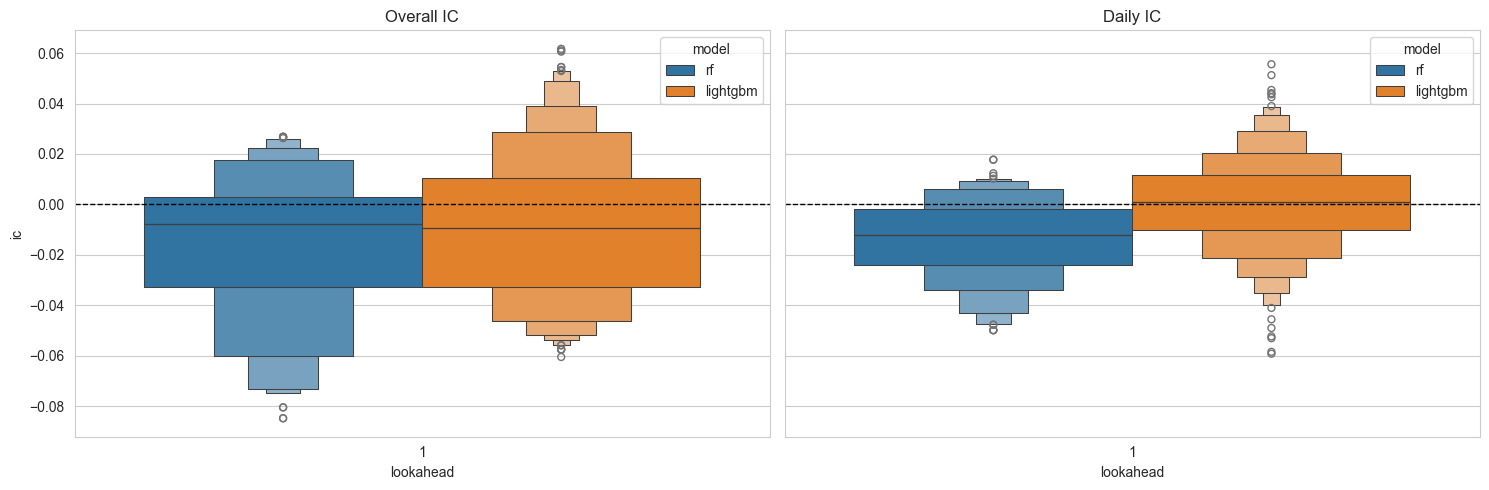

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(
    x="lookahead",
    y="ic",
    hue="model",
    data=pd.concat(
        [rf_metrics.assign(model="rf"), lgb_metrics.assign(model="lightgbm")]
    ),
    ax=axes[0],
)
axes[0].axhline(0, ls="--", lw=1, c="k")
axes[0].set_title("Overall IC")
sns.boxenplot(
    x="lookahead",
    y="ic",
    hue="model",
    data=pd.concat(
        [rf_daily_ic.assign(model="rf"), lgb_daily_ic.assign(model="lightgbm")]
    ),
    ax=axes[1],
)
axes[1].axhline(0, ls="--", lw=1, c="k")
axes[1].set_title("Daily IC")
fig.tight_layout()

## HyperParameter Impact: Linear Regression

Next, we'd like to understand if there's a systematic, statistical relationship between the hyperparameters and the outcomes across daily predictions. To this end, we will run a linear regression using the various LightGBM hyperparameter settings as dummy variables and the daily validation IC as the outcome.

The below chart shows the coefficient estimates and their confidence intervals for 1- and 21-day forecast horizons (1 y 2 horizonte mensual en nuestro caso).
- For the shorter horizon, a longer lookback period, a higher learning rate, and deeper trees (more leaf nodes) have a positive impact.
- For the longer horizon, the picture is a little less clear: shorter trees do better, but the lookback period is not significant. A higher feature sampling rate also helps. In both cases, a larger ensemble does better.

Note that these results apply to this specific example only.

In [ ]:
lin_reg = {}
for t in [1]:
    df_ = lgb_ic[lgb_ic.lookahead == t]
    y, X = df_.ic, df_.drop(["ic"], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)  # Added
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip()
    )
    coefs.columns = ["variable", "coef", "std_err", "t", "p_value", "ci_low", "ci_high"]
    coefs.to_csv(f"results/linreg_result_{t:02}.csv", index=False)

In [ ]:
import numpy as np

In [ ]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (
        model.params.to_frame("coef")
        .assign(error=errors)
        .reset_index()
        .rename(columns={"index": "variable"})
    )
    coefs = coefs[
        ~coefs["variable"].str.startswith("date") & (coefs.variable != "const")
    ]

    coefs.plot(
        x="variable",
        y="coef",
        kind="bar",
        ax=ax,
        color="none",
        capsize=3,
        yerr="error",
        legend=False,
    )
    ax.set_ylabel("IC")
    ax.set_xlabel("")
    # ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.scatter(
        x=np.arange(len(coefs)), marker="_", s=120, y=coefs["coef"], color="black"
    )
    ax.axhline(y=0, linestyle="--", color="black", linewidth=1)
    ax.xaxis.set_ticks_position("none")

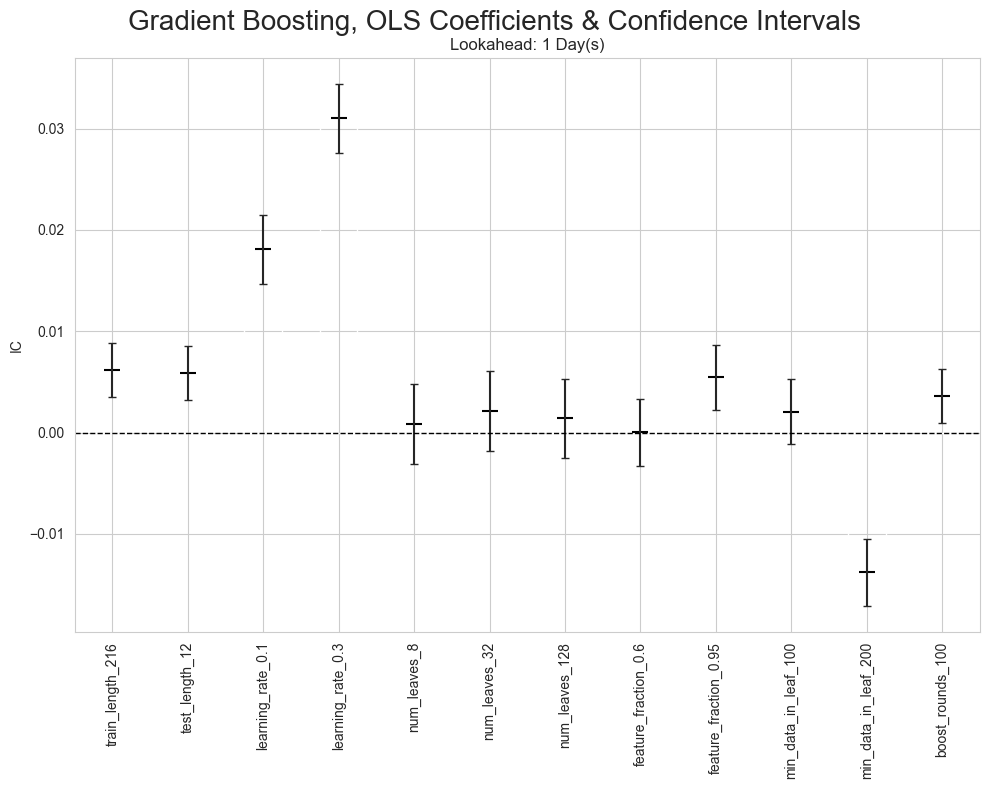

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
axes = [axes]

for i, t in enumerate([1]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f"Lookahead: {t} Day(s)")
fig.suptitle("OLS Coefficients & Confidence Intervals", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

# Lo mismo para RF

In [ ]:
lin_reg = {}
# for t in [1, 2]:
for t in [1]:
    df_ = rf_ic[rf_ic.lookahead == t]
    y, X = df_.ic, df_.drop(["ic"], axis=1)
    # X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns))
    X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)  # Added
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(
        columns=lambda x: x.strip()
    )
    coefs.columns = ["variable", "coef", "std_err", "t", "p_value", "ci_low", "ci_high"]
    coefs.to_csv(f"results/linreg_result_{t:02}.csv", index=False)

In [ ]:
X

,const,date_2007-01-21 00:00:00,date_2007-01-28 00:00:00,date_2007-02-04 00:00:00,date_2007-02-11 00:00:00,date_2007-02-18 00:00:00,date_2007-02-25 00:00:00,date_2007-03-04 00:00:00,date_2007-03-11 00:00:00,date_2007-03-18 00:00:00,...,feature_fraction_0.75,feature_fraction_0.95,min_data_in_leaf_89,min_data_in_leaf_100,min_data_in_leaf_200,max_depth_-1,max_depth_5,max_depth_10,boost_rounds_50,boost_rounds_100
6,1.0,0,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,1,1,0
8,1.0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,1,0
10,1.0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
11,1.0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
12,1.0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89849,1.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
89850,1.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
89851,1.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1
89852,1.0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1


In [ ]:
coefs.tail(20)

,variable,coef,std_err,t,p_value,ci_low,ci_high
622,date_2018-12-16 00:00:00,-3.527000e+09,1.170000e+10,-0.301,0.763,-2.650000e+10,1.940000e+10
623,date_2018-12-23 00:00:00,-3.527000e+09,1.170000e+10,-0.301,0.763,-2.650000e+10,1.940000e+10
624,date_2018-12-30 00:00:00,-3.527000e+09,1.170000e+10,-0.301,0.763,-2.650000e+10,1.940000e+10
625,lookahead_1,-2.157000e+11,1.680000e+11,-1.283,0.199,-5.450000e+11,1.140000e+11
626,train_length_52,-7.173000e+10,5.650000e+10,-1.270,0.204,-1.820000e+11,3.900000e+10
627,train_length_216,-7.173000e+10,5.650000e+10,-1.270,0.204,-1.820000e+11,3.900000e+10
628,test_length_1,-4.995000e+10,4.870000e+10,-1.025,0.306,-1.450000e+11,4.560000e+10
629,test_length_12,-4.995000e+10,4.870000e+10,-1.025,0.306,-1.450000e+11,4.560000e+10
630,bagging_fraction_0.75,-3.922000e+10,4.100000e+10,-0.956,0.339,-1.200000e+11,4.120000e+10
631,bagging_fraction_0.95,-3.922000e+10,4.100000e+10,-0.956,0.339,-1.200000e+11,4.120000e+10


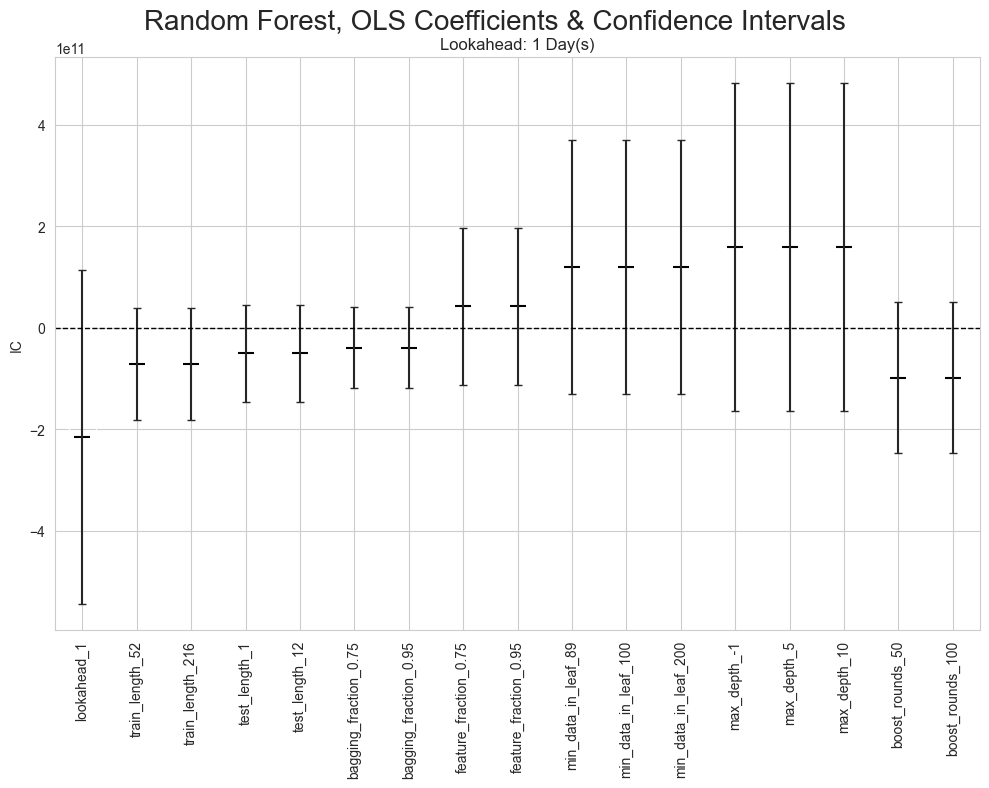

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
axes = [axes]

for i, t in enumerate([1]):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f"Lookahead: {t} Day(s)")
fig.suptitle("OLS Coefficients & Confidence Intervals", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [ ]:
group_cols = scope_params + lgb_train_params + ["boost_rounds"]
lgb_daily_ic.groupby("lookahead", group_keys=False).apply(
    lambda x: x.nlargest(10, "ic")
)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,boost_rounds,ic
410,1,216,12,0.3,4,0.95,100,50,0.055571
411,1,216,12,0.3,4,0.95,100,100,0.051246
431,1,216,12,0.3,128,0.95,200,100,0.045379
420,1,216,12,0.3,32,0.30,100,50,0.044124
430,1,216,12,0.3,128,0.95,200,50,0.043647
312,1,216,1,0.3,32,0.95,100,50,0.042495
414,1,216,12,0.3,8,0.30,50,50,0.038985
416,1,216,12,0.3,8,0.60,100,50,0.038667
422,1,216,12,0.3,32,0.95,100,50,0.037954
415,1,216,12,0.3,8,0.30,50,100,0.037099


In [ ]:
lgb_metrics.groupby("lookahead", group_keys=False).apply(lambda x: x.nlargest(3, "ic"))
lgb_metrics.groupby("lookahead", group_keys=False).apply(
    lambda x: x.nlargest(3, "ic")
).to_csv("results/best_lgb_model.csv", index=False)

In [ ]:
lgb_metrics.groupby("lookahead", group_keys=False).apply(
    lambda x: x.nlargest(10, "daily_ic_mean")
)

,lookahead,train_length,test_length,learning_rate,num_leaves,feature_fraction,min_data_in_leaf,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
110,1,216,12,0.3,4.0,0.95,100.0,0.055571,50.0,0.066806,50.0,50,0.048847
326,1,216,12,0.3,4.0,0.95,100.0,0.055571,50.0,0.066806,50.0,100,0.054501
117,1,216,12,0.3,128.0,0.95,200.0,0.045379,100.0,0.066667,100.0,50,0.060580
333,1,216,12,0.3,128.0,0.95,200.0,0.045379,100.0,0.066667,100.0,100,0.061069
115,1,216,12,0.3,32.0,0.30,100.0,0.044124,50.0,0.050000,50.0,50,0.021901
331,1,216,12,0.3,32.0,0.30,100.0,0.044124,50.0,0.050000,50.0,100,0.026353
173,1,216,1,0.3,32.0,0.95,100.0,0.042495,50.0,0.050000,50.0,50,-0.034229
389,1,216,1,0.3,32.0,0.95,100.0,0.042495,50.0,0.050000,50.0,100,-0.028637
109,1,216,12,0.3,8.0,0.30,50.0,0.038985,50.0,0.058333,50.0,50,0.052889
325,1,216,12,0.3,8.0,0.30,50.0,0.038985,50.0,0.058333,50.0,100,0.045655


### Random Forest

The top-performing RF models use the following parameters for the three different prediction horizons.

In [ ]:
group_cols = scope_params + rf_train_params + ["boost_rounds"]
rf_daily_ic.groupby("lookahead", group_keys=False).apply(lambda x: x.nlargest(10, "ic"))

,lookahead,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,max_depth,boost_rounds,ic
53,1,52,12,0.95,0.95,89,5,100,0.017733
55,1,52,12,0.95,0.95,89,10,100,0.017733
120,1,216,12,0.95,0.75,89,-1,50,0.012353
60,1,216,1,0.75,0.75,89,-1,50,0.011339
73,1,216,1,0.75,0.95,89,10,100,0.010214
91,1,216,1,0.95,0.95,100,-1,100,0.009884
62,1,216,1,0.75,0.75,100,-1,50,0.009694
6,1,52,1,0.75,0.95,89,5,50,0.009486
8,1,52,1,0.75,0.95,89,10,50,0.009486
128,1,216,12,0.95,0.95,89,-1,50,0.009243


In [ ]:
rf_metrics.groupby("lookahead", group_keys=False).apply(lambda x: x.nlargest(3, "ic"))
rf_metrics.groupby("lookahead", group_keys=False).apply(
    lambda x: x.nlargest(3, "ic")
).to_csv("results/best_rf_model.csv", index=False)

In [ ]:
rf_metrics.groupby("lookahead", group_keys=False).apply(
    lambda x: x.nlargest(10, "daily_ic_mean")
)

,lookahead,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,max_depth,daily_ic_mean,daily_ic_mean_n,daily_ic_median,daily_ic_median_n,boost_rounds,ic
0,1,52,12,0.95,0.95,89.0,10.0,0.017733,100.0,0.027524,100.0,50,-0.006404
1,1,52,12,0.95,0.95,89.0,5.0,0.017733,100.0,0.027524,100.0,50,-0.006404
72,1,52,12,0.95,0.95,89.0,10.0,0.017733,100.0,0.027524,100.0,100,-0.005645
73,1,52,12,0.95,0.95,89.0,5.0,0.017733,100.0,0.027524,100.0,100,-0.005645
38,1,216,12,0.95,0.75,89.0,-1.0,0.012353,50.0,0.025483,100.0,50,-0.000720
110,1,216,12,0.95,0.75,89.0,-1.0,0.012353,50.0,0.025483,100.0,100,-0.002310
67,1,216,1,0.75,0.75,89.0,-1.0,0.011339,50.0,0.017568,50.0,50,-0.012740
139,1,216,1,0.75,0.75,89.0,-1.0,0.011339,50.0,0.017568,50.0,100,-0.012476
61,1,216,1,0.75,0.95,89.0,10.0,0.010214,100.0,0.008513,100.0,50,-0.033032
133,1,216,1,0.75,0.95,89.0,10.0,0.010214,100.0,0.008513,100.0,100,-0.026058


sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

### Visualization

#### LightGBM

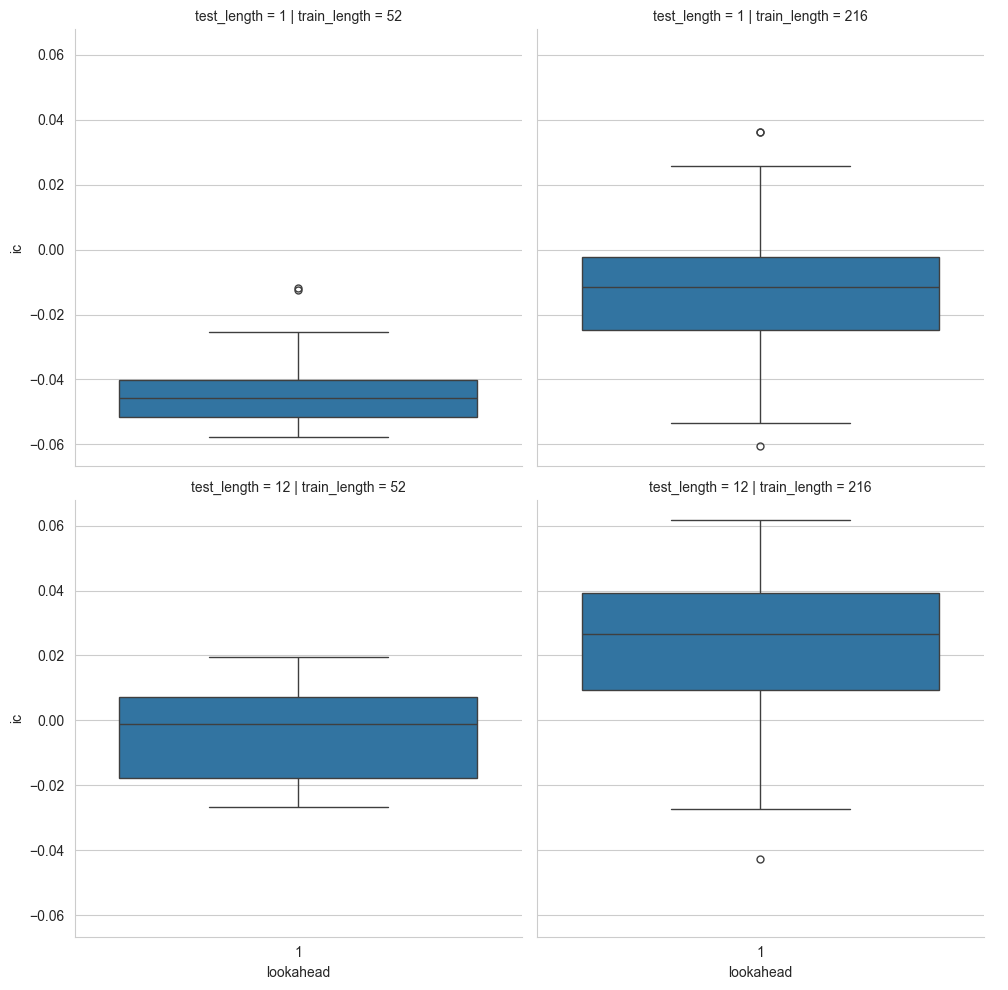

In [ ]:
g = sns.catplot(
    x="lookahead",
    y="ic",
    col="train_length",
    row="test_length",
    data=lgb_metrics,
    kind="box",
)

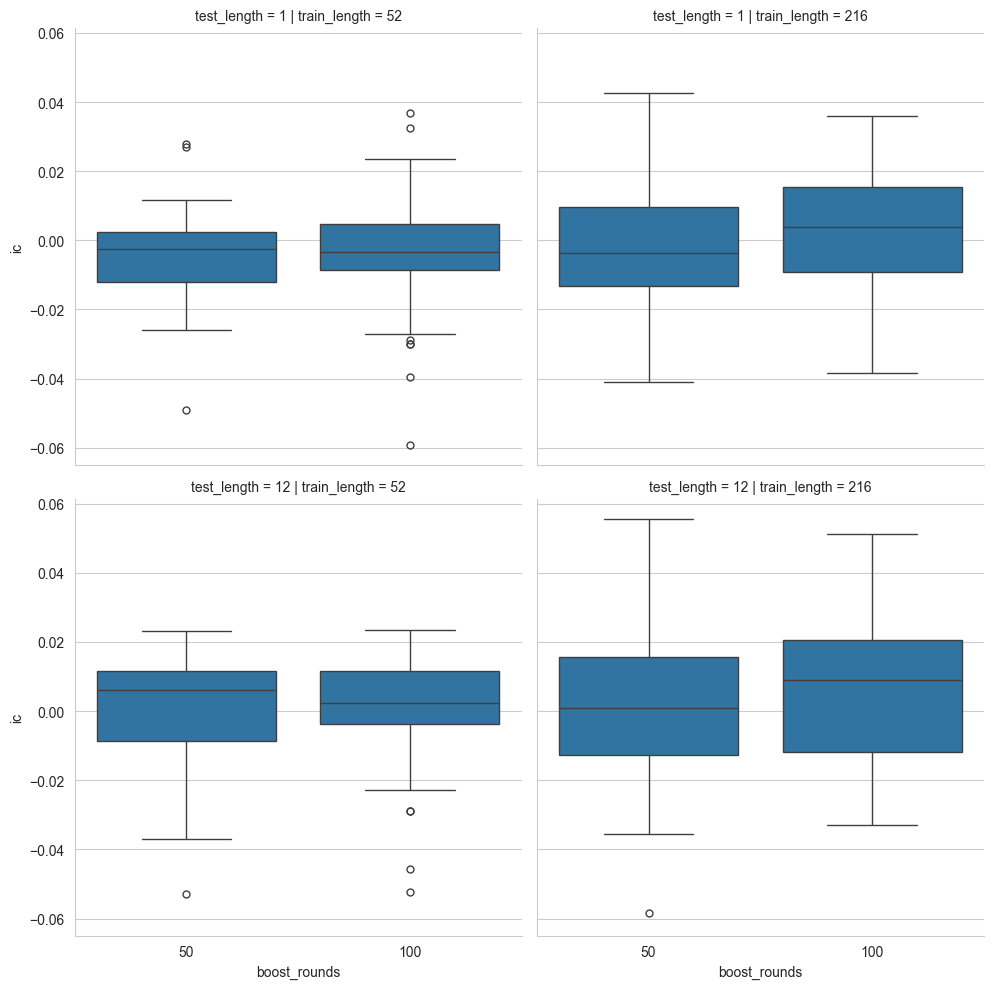

In [ ]:
t = 1
g = sns.catplot(
    x="boost_rounds",
    y="ic",
    col="train_length",
    row="test_length",
    data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
    kind="box",
)

### Random forest

#### Random Forest

Some figures are empty because we did not run those parameter combinations.

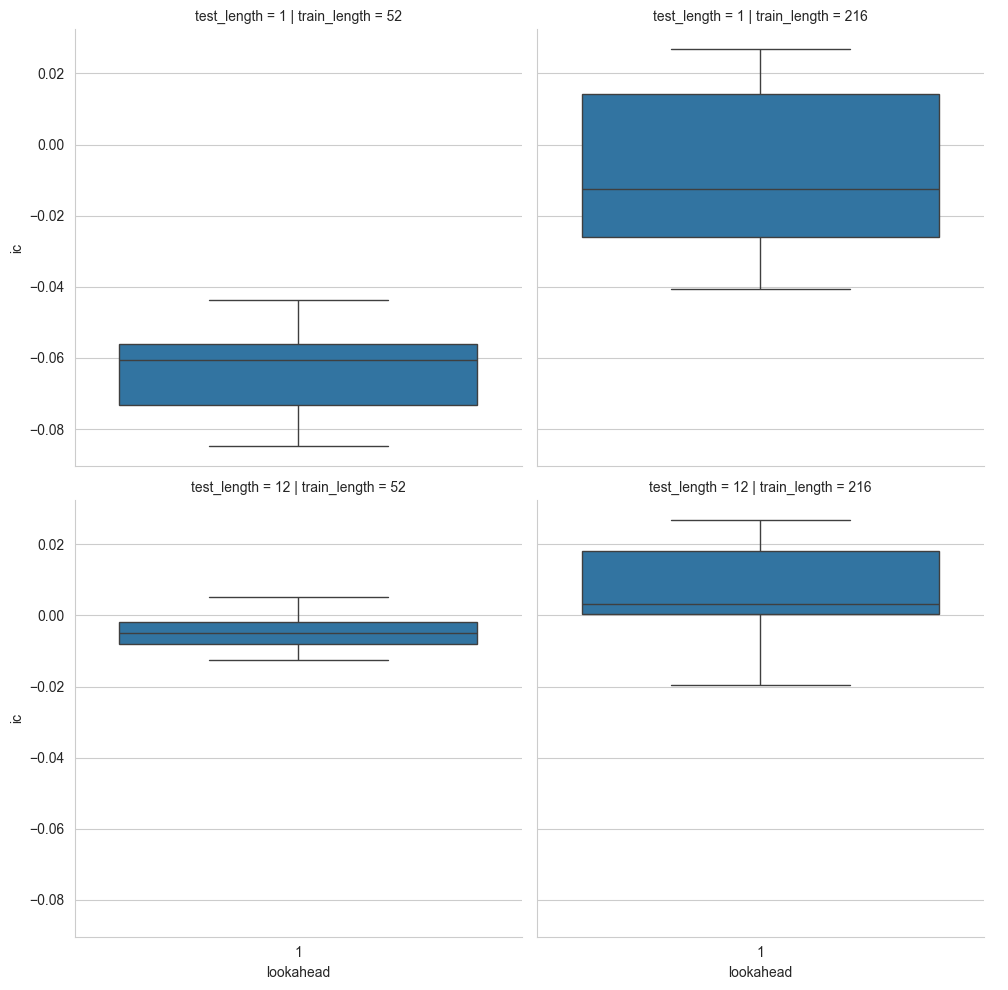

In [ ]:
g = sns.catplot(
    x="lookahead",
    y="ic",
    col="train_length",
    row="test_length",
    data=rf_metrics,
    kind="box",
)

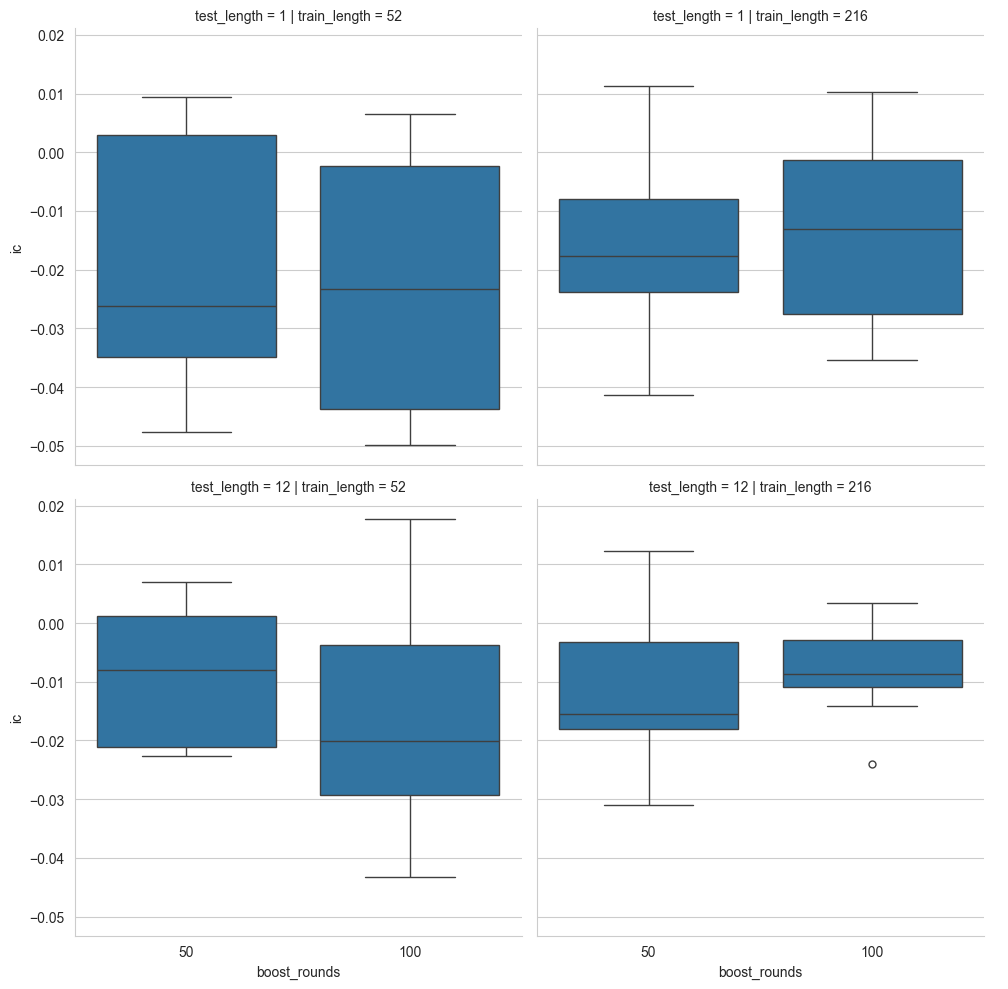

In [ ]:
t = 1
g = sns.catplot(
    x="boost_rounds",
    y="ic",
    col="train_length",
    row="test_length",
    data=rf_daily_ic[rf_daily_ic.lookahead == t],
    kind="box",
)

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [ ]:
lgb_daily_ic = pd.read_hdf("data/model_tuning.h5", "lgb/daily_ic")
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 432 entries, 0 to 431
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         432 non-null    int64  
 1   train_length      432 non-null    int64  
 2   test_length       432 non-null    int64  
 3   learning_rate     432 non-null    float64
 4   num_leaves        432 non-null    int64  
 5   feature_fraction  432 non-null    float64
 6   min_data_in_leaf  432 non-null    int64  
 7   boost_rounds      432 non-null    int64  
 8   ic                432 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 33.8 KB


In [ ]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ["boost_rounds"]
    df = data[data.lookahead == t].sort_values("ic", ascending=False).iloc[best]
    return df.loc[param_cols]

In [ ]:
def get_lgb_key(t, p):
    key = f"{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/"
    return key + f"{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}"

In [ ]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length        216.00
test_length          12.00
learning_rate         0.30
num_leaves            4.00
feature_fraction      0.95
min_data_in_leaf    100.00
boost_rounds         50.00
Name: 410, dtype: float64

In [ ]:
best_params.to_hdf("data.h5", "best_params")

#### Plot rolling IC

In [ ]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[
        (ic_data.lookahead == lookahead)
        & (ic_data.train_length == params.train_length)
        & (ic_data.test_length == params.test_length)
        & (ic_data.learning_rate == params.learning_rate)
        & (ic_data.num_leaves == params.num_leaves)
        & (ic_data.feature_fraction == params.feature_fraction)
        & (ic_data.boost_rounds == params.boost_rounds),
        ["date", "ic"],
    ].set_index("date")

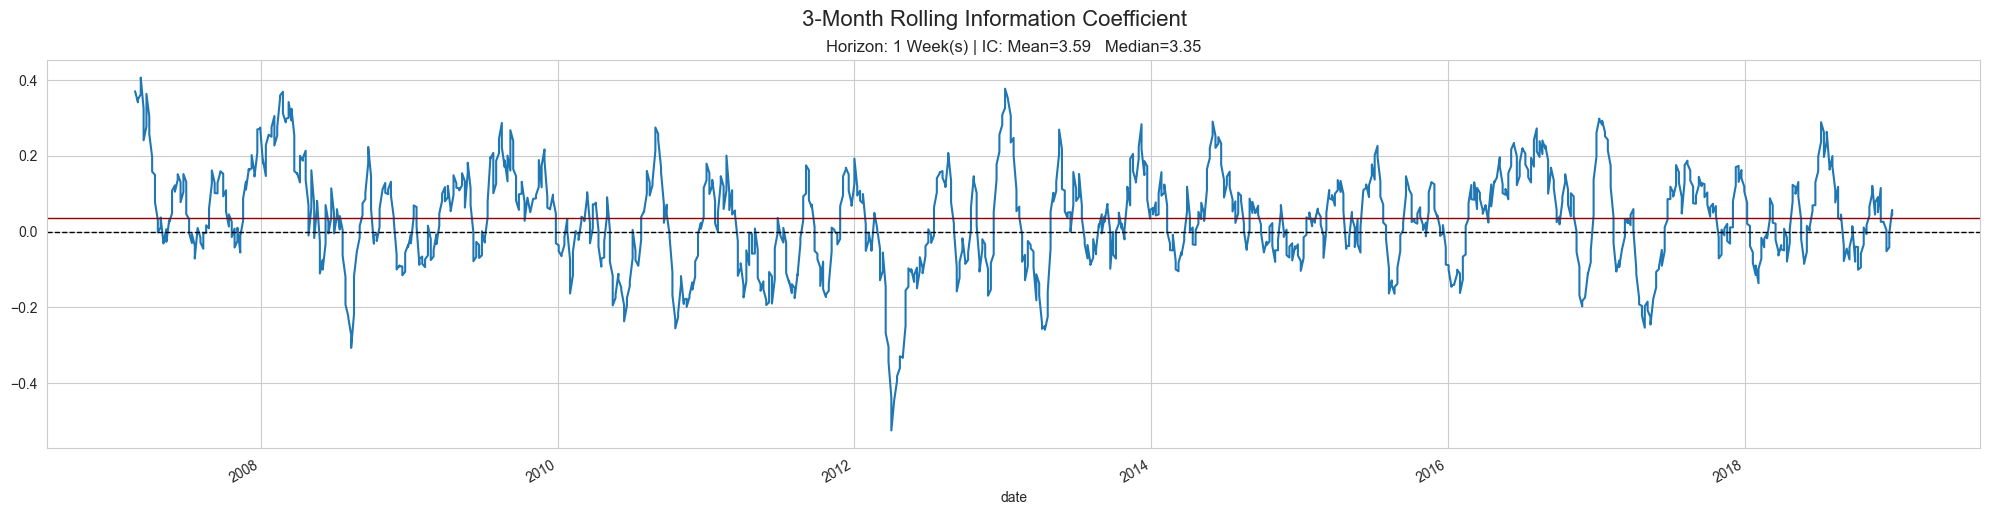

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
axes = [axes]


for i, t in enumerate([1]):
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    # rolling = data.rolling(63).ic.mean().dropna()
    rolling = data.rolling(3 * 4).ic.mean().dropna()  # semanas
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(
        ax=axes[i],
        title=f"Horizon: {t} Week(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}",
    )
    axes[i].axhline(avg, c="darkred", lw=1)
    axes[i].axhline(0, ls="--", c="k", lw=1)

fig.suptitle("3-Month Rolling Information Coefficient", fontsize=16, y=1.02)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

In [ ]:
t

1

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [ ]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(
            results_path / "tuning_lgb.h5", "predictions/" + key
        )
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(
            results_path / "tuning_lgb.h5", "predictions/" + key
        )[rounds]
best_predictions = best_predictions.sort_index()

In [ ]:
best_predictions.to_hdf("data/predictions.h5", f"lgb/train/{lookahead:02}")
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5616 entries, ('XLB', Timestamp('2007-01-21 00:00:00')) to ('XLY', Timestamp('2018-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5616 non-null   float64
 1   1       5616 non-null   float64
 2   2       5616 non-null   float64
 3   3       5616 non-null   float64
 4   4       5616 non-null   float64
 5   5       5616 non-null   float64
 6   6       5616 non-null   float64
 7   7       5616 non-null   float64
 8   8       5616 non-null   float64
 9   9       5616 non-null   float64
dtypes: float64(10)
memory usage: 498.7+ KB


#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [ ]:
# modificado


def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = "../data/assets.h5"
    with pd.HDFStore(DATA_STORE) as store:
        prices = store["data_close"]

    return (
        prices.loc[idx[tickers, "2012":"2024"], "open"]
        .unstack("ticker")
        .sort_index()
        .shift(-1)
        .tz_localize("UTC")
        .resample("W")
        .last()
    )

In [ ]:
test_tickers = best_predictions.index.get_level_values("ticker").unique()  # modificado

In [ ]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 679 entries, 2012-01-08 00:00:00+00:00 to 2025-01-05 00:00:00+00:00
Freq: W-SUN
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLB     679 non-null    float64
 1   XLE     679 non-null    float64
 2   XLF     679 non-null    float64
 3   XLI     679 non-null    float64
 4   XLK     679 non-null    float64
 5   XLP     679 non-null    float64
 6   XLU     679 non-null    float64
 7   XLV     679 non-null    float64
 8   XLY     679 non-null    float64
dtypes: float64(9)
memory usage: 53.0 KB


In [ ]:
# persist result in case we want to rerun:
trade_prices.to_hdf("data/model_tuning.h5", "trade_prices/model_selection")
trade_prices = pd.read_hdf("data/model_tuning.h5", "trade_prices/model_selection")

In [ ]:
trade_prices.tail()

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2024-12-08 00:00:00+00:00,91.722153,90.312075,50.044032,139.457722,239.127660,81.447295,78.478209,143.214983,233.055629
2024-12-15 00:00:00+00:00,88.167723,87.547014,49.180863,136.471957,238.549614,81.022779,76.528311,139.704521,235.613723
2024-12-22 00:00:00+00:00,84.626601,82.665267,47.886068,132.582735,235.835923,78.633478,75.077131,137.069694,228.261709
2024-12-29 00:00:00+00:00,83.989640,83.915525,48.075380,131.406343,233.619820,78.543949,75.206211,137.617556,225.628952
2025-01-05 00:00:00+00:00,83.681109,84.094132,48.224837,131.924753,234.697929,78.116213,75.375021,137.049766,226.656127


We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [ ]:
factor = (
    best_predictions.iloc[:, :5]
    .mean(1)
    .dropna()
    .tz_localize("UTC", level="date")
    .swaplevel()
)

In [ ]:
factor.tail()

date                       ticker
2018-12-02 00:00:00+00:00  XLY       0.587216
2018-12-09 00:00:00+00:00  XLY       1.333278
2018-12-16 00:00:00+00:00  XLY       0.358216
2018-12-23 00:00:00+00:00  XLY       1.102963
2018-12-30 00:00:00+00:00  XLY       0.706295
dtype: float64

In [ ]:
# trade_prices= trade_prices.asfreq('W')

In [ ]:
trade_prices.tail()

ticker,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,
2024-12-08 00:00:00+00:00,91.722153,90.312075,50.044032,139.457722,239.127660,81.447295,78.478209,143.214983,233.055629
2024-12-15 00:00:00+00:00,88.167723,87.547014,49.180863,136.471957,238.549614,81.022779,76.528311,139.704521,235.613723
2024-12-22 00:00:00+00:00,84.626601,82.665267,47.886068,132.582735,235.835923,78.633478,75.077131,137.069694,228.261709
2024-12-29 00:00:00+00:00,83.989640,83.915525,48.075380,131.406343,233.619820,78.543949,75.206211,137.617556,225.628952
2025-01-05 00:00:00+00:00,83.681109,84.094132,48.224837,131.924753,234.697929,78.116213,75.375021,137.049766,226.656127


In [ ]:
freq = pd.infer_freq(trade_prices.index)
print(freq)

W-SUN


#### Create AlphaLens Inputs

In [ ]:
factor_data = get_clean_factor_and_forward_returns(
    factor=factor,
    prices=trade_prices,
    quantiles=5,
    # periods=(1, 2))#modificado
    periods=(1, 2),
    max_loss=2,
)  # modificado

Dropped 41.5% entries from factor data: 41.5% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 200.0%, not exceeded: OK!


#### Compute Alphalens metrics

In [ ]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [ ]:
factor_returns = perf.factor_returns(factor_data)

In [ ]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(
    factor_data, by_group=False, demeaned=True
)


mean_quant_rateret = mean_quant_ret.apply(
    rate_of_return, axis=0, base_period=mean_quant_ret.columns[0]
)

In [ ]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(
    std_conversion, base_period=std_quant_daily.columns[0]
)

alpha_beta = perf.factor_alpha_beta(factor_data, demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [ ]:
mean_ret_spread_quant.mean().mul(10000).to_frame("Mean Period Wise Spread (bps)").join(
    alpha_beta.T
).T

,1D,2D
Mean Period Wise Spread (bps),13.894488,7.852377
Ann. alpha,0.133274,0.063970
beta,0.004431,0.012967


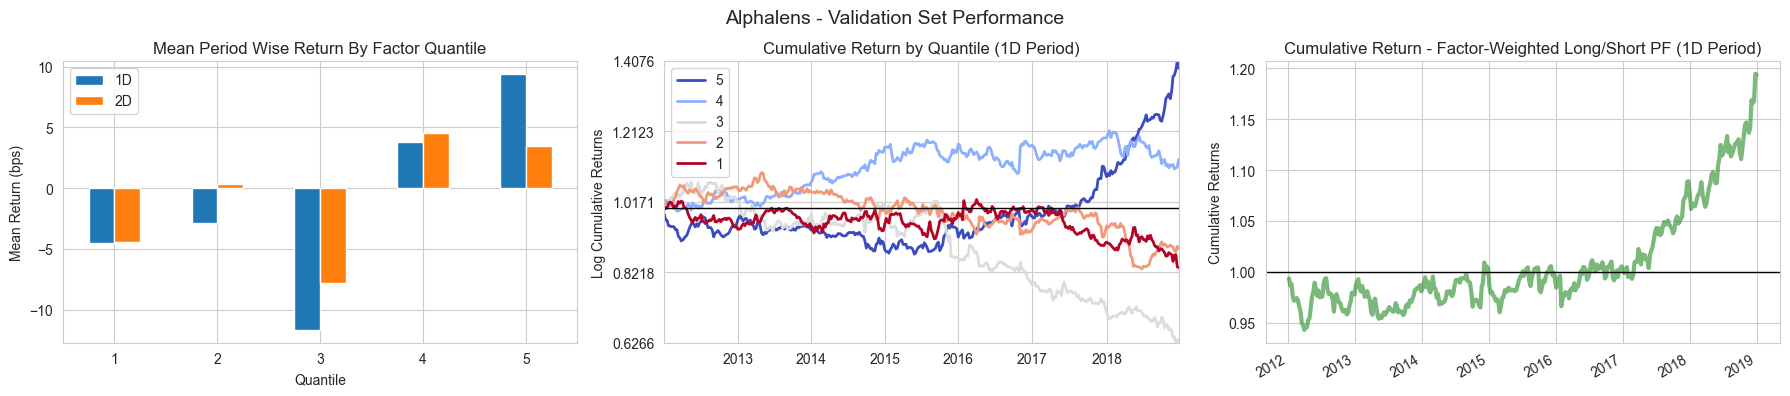

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel("Quantile")

plotting.plot_cumulative_returns_by_quantile(
    mean_quant_ret_bydate["1D"], freq=pd.tseries.offsets.BDay(), period="1D", ax=axes[1]
)
axes[1].set_title("Cumulative Return by Quantile (1D Period)")

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(
    factor_returns["1D"],
    period="1D",
    freq=pd.tseries.offsets.BDay(),
    title=title,
    ax=axes[2],
)

fig.suptitle("Alphalens - Validation Set Performance", fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.85);

#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.540144,1.728839,-0.080818,0.453188,730,22.222222
2,-1.071807,1.991268,0.015963,0.452931,730,22.222222
3,-1.056786,2.014444,0.064336,0.453356,365,11.111111
4,-1.021660,2.043254,0.116174,0.457077,730,22.222222
5,-0.916500,2.138860,0.212010,0.469015,730,22.222222


Returns Analysis


,1D,2D
Ann. alpha,0.133,0.064
beta,0.004,0.013
Mean Period Wise Return Top Quantile (bps),9.402,3.423
Mean Period Wise Return Bottom Quantile (bps),-4.493,-4.409
Mean Period Wise Spread (bps),13.894,7.852


Information Analysis


,1D,2D
IC Mean,0.039,0.019
IC Std.,0.404,0.392
Risk-Adjusted IC,0.097,0.048
t-stat(IC),1.859,0.921
p-value(IC),0.064,0.358
IC Skew,-0.153,0.065
IC Kurtosis,-0.625,-0.723


Turnover Analysis


,1D,2D
Quantile 1 Mean Turnover,0.650,0.639
Quantile 2 Mean Turnover,0.751,0.755
Quantile 3 Mean Turnover,0.843,0.906
Quantile 4 Mean Turnover,0.762,0.741
Quantile 5 Mean Turnover,0.681,0.664


,1D,2D
Mean Factor Rank Autocorrelation,0.266,0.246


<Figure size 640x480 with 0 Axes>

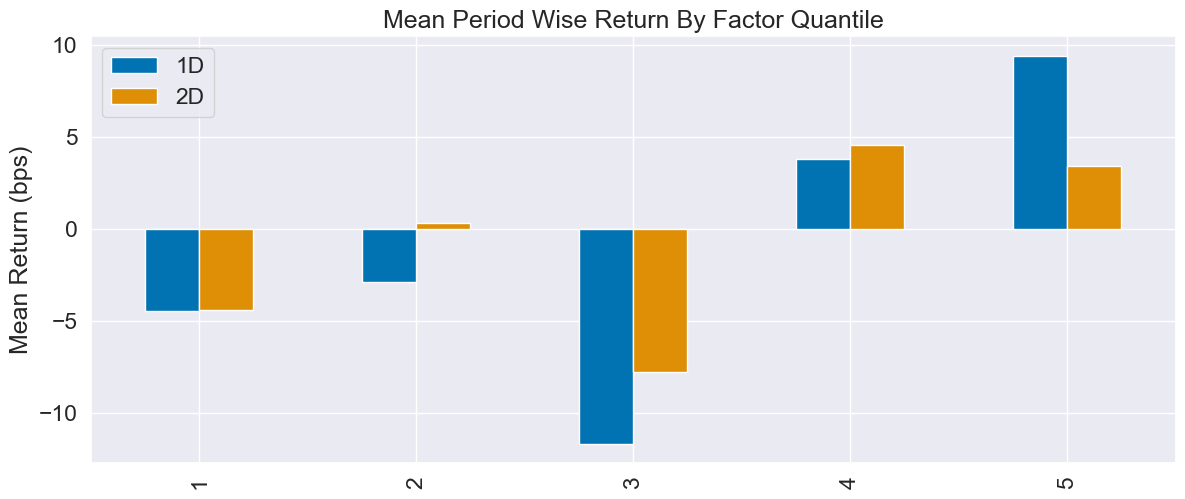

In [ ]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.540144,1.728839,-0.080818,0.453188,730,22.222222
2,-1.071807,1.991268,0.015963,0.452931,730,22.222222
3,-1.056786,2.014444,0.064336,0.453356,365,11.111111
4,-1.021660,2.043254,0.116174,0.457077,730,22.222222
5,-0.916500,2.138860,0.212010,0.469015,730,22.222222


Returns Analysis


,1D,2D
Ann. alpha,0.133,0.064
beta,0.004,0.013
Mean Period Wise Return Top Quantile (bps),9.402,3.423
Mean Period Wise Return Bottom Quantile (bps),-4.493,-4.409
Mean Period Wise Spread (bps),13.894,7.852


<Figure size 640x480 with 0 Axes>

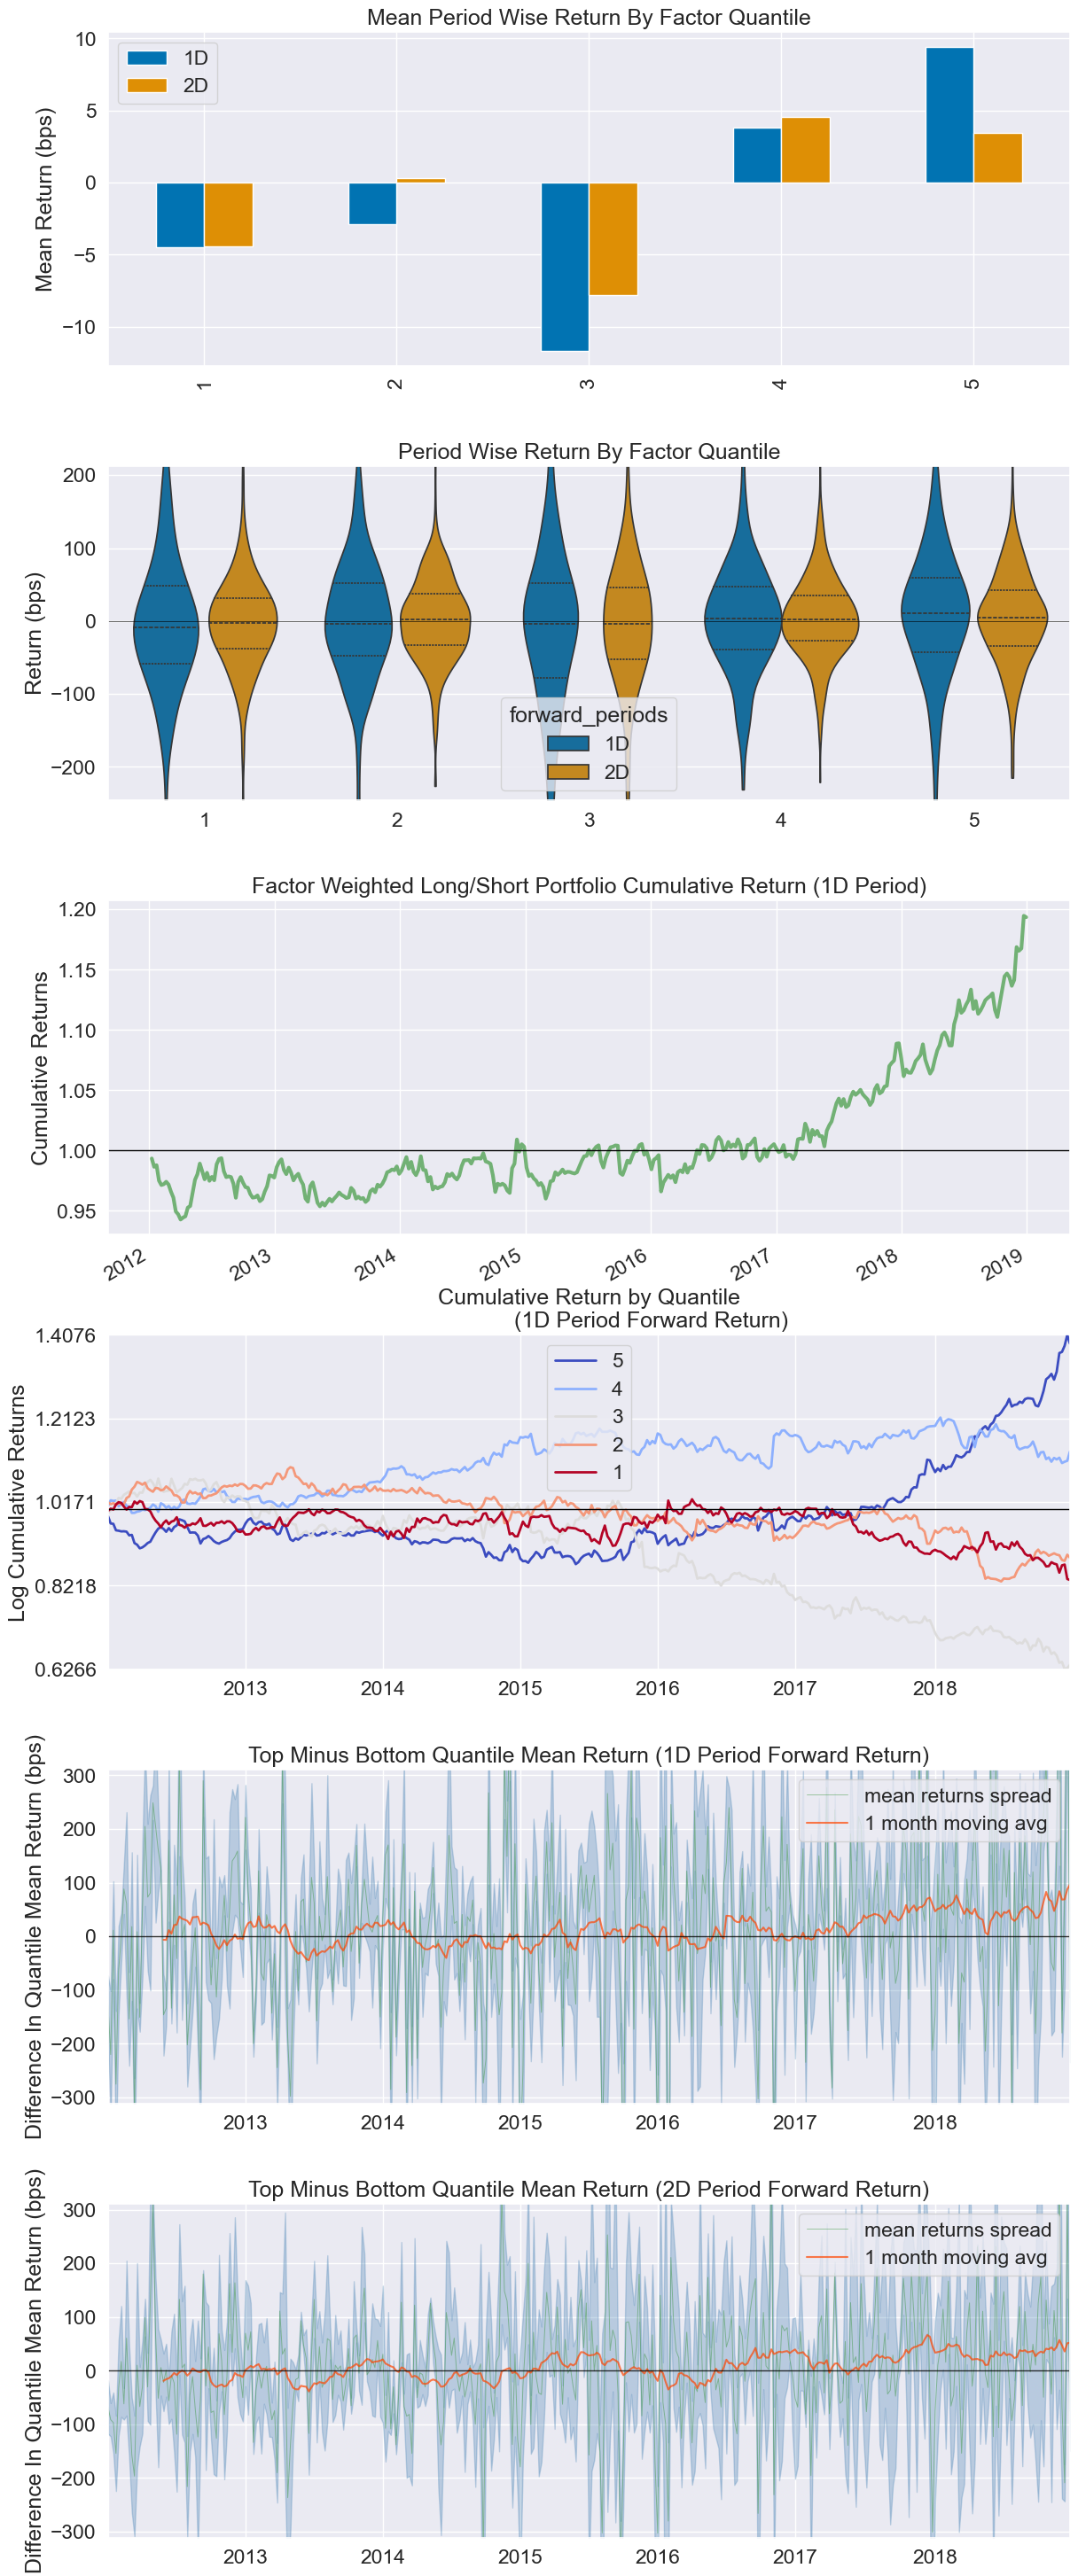

Information Analysis


,1D,2D
IC Mean,0.039,0.019
IC Std.,0.404,0.392
Risk-Adjusted IC,0.097,0.048
t-stat(IC),1.859,0.921
p-value(IC),0.064,0.358
IC Skew,-0.153,0.065
IC Kurtosis,-0.625,-0.723


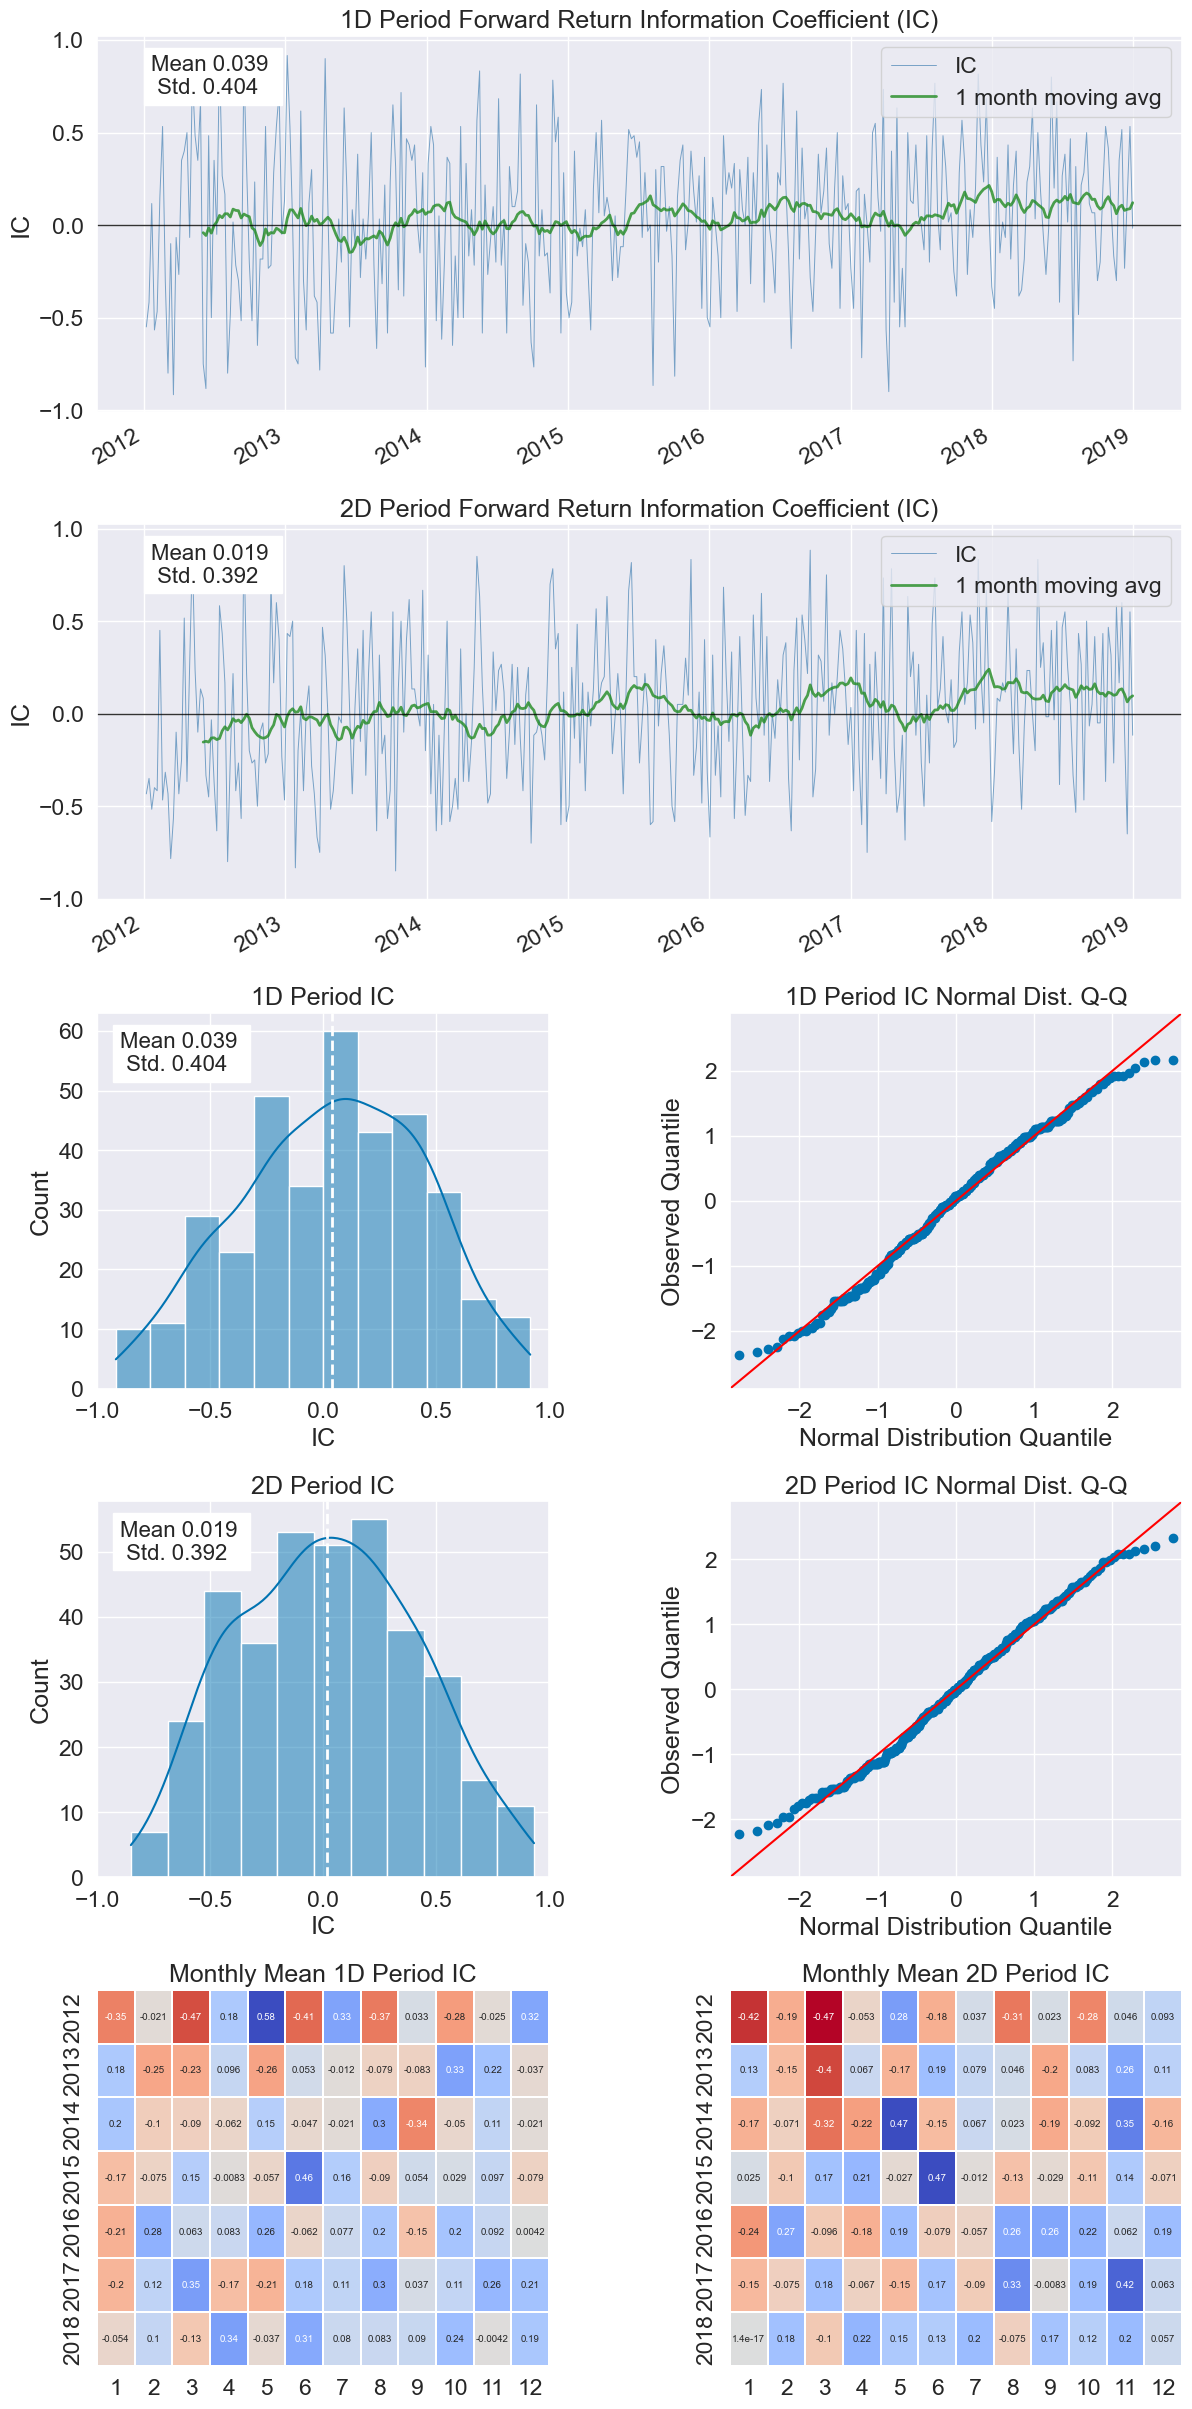

Turnover Analysis


,1D,2D
Quantile 1 Mean Turnover,0.650,0.639
Quantile 2 Mean Turnover,0.751,0.755
Quantile 3 Mean Turnover,0.843,0.906
Quantile 4 Mean Turnover,0.762,0.741
Quantile 5 Mean Turnover,0.681,0.664


,1D,2D
Mean Factor Rank Autocorrelation,0.266,0.246


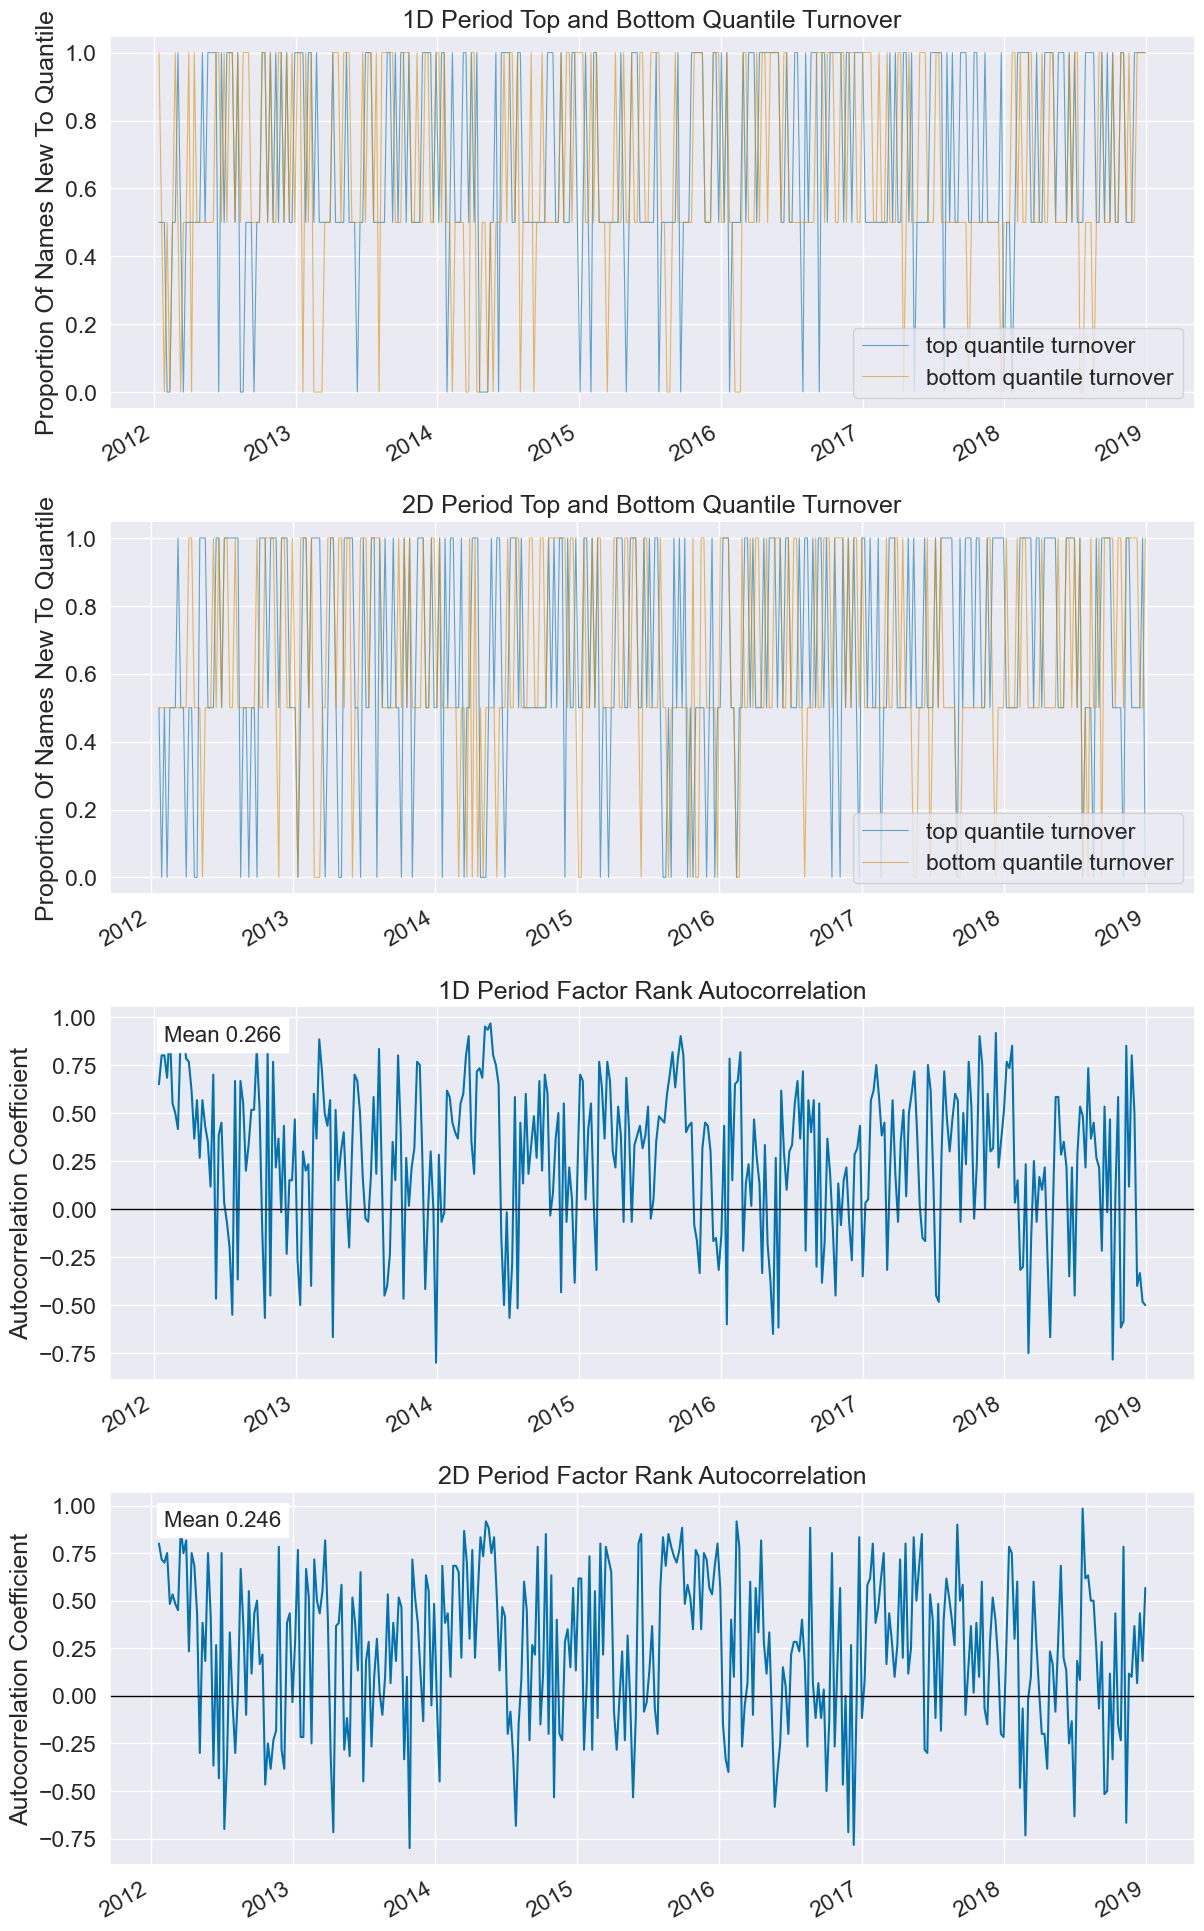

In [ ]:
create_full_tear_sheet(factor_data)

### Random Forest

#### Select Parameters

In [ ]:
rf_daily_ic = pd.read_hdf("data/model_tuning.h5", "rf/daily_ic")
rf_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132 entries, 0 to 131
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         132 non-null    int64  
 1   train_length      132 non-null    int64  
 2   test_length       132 non-null    int64  
 3   bagging_fraction  132 non-null    float64
 4   feature_fraction  132 non-null    float64
 5   min_data_in_leaf  132 non-null    int64  
 6   max_depth         132 non-null    int64  
 7   boost_rounds      132 non-null    int64  
 8   ic                132 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 10.3 KB


In [ ]:
def get_rf_params(data, t=5, best=0):
    param_cols = scope_params[1:] + rf_train_params + ["boost_rounds"]
    df = data[data.lookahead == t].sort_values("ic", ascending=False).iloc[best]
    return df.loc[param_cols]

In [ ]:
def get_rf_key(t, p):
    key = f"{t}/{int(p.train_length)}/{int(p.test_length)}/{p.bagging_fraction}/"
    return key + f"{p.feature_fraction}/{int(p.min_data_in_leaf)}/{int(p.max_depth)}"

In [ ]:
best_params_rf = get_rf_params(rf_daily_ic, t=1, best=0)
best_params_rf

train_length         52.00
test_length          12.00
bagging_fraction      0.95
feature_fraction      0.95
min_data_in_leaf     89.00
max_depth             5.00
boost_rounds        100.00
Name: 53, dtype: float64

In [ ]:
best_params_rf.to_hdf("data.h5", "best_params_rf")

#### Plot rolling IC

In [ ]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[
        (ic_data.lookahead == lookahead)
        & (ic_data.train_length == params.train_length)
        & (ic_data.test_length == params.test_length)
        & (ic_data.bagging_fraction == params.bagging_fraction)
        & (ic_data.feature_fraction == params.feature_fraction)
        & (ic_data.max_depth == params.max_depth)
        & (ic_data.boost_rounds == params.boost_rounds),
        ["date", "ic"],
    ].set_index("date")

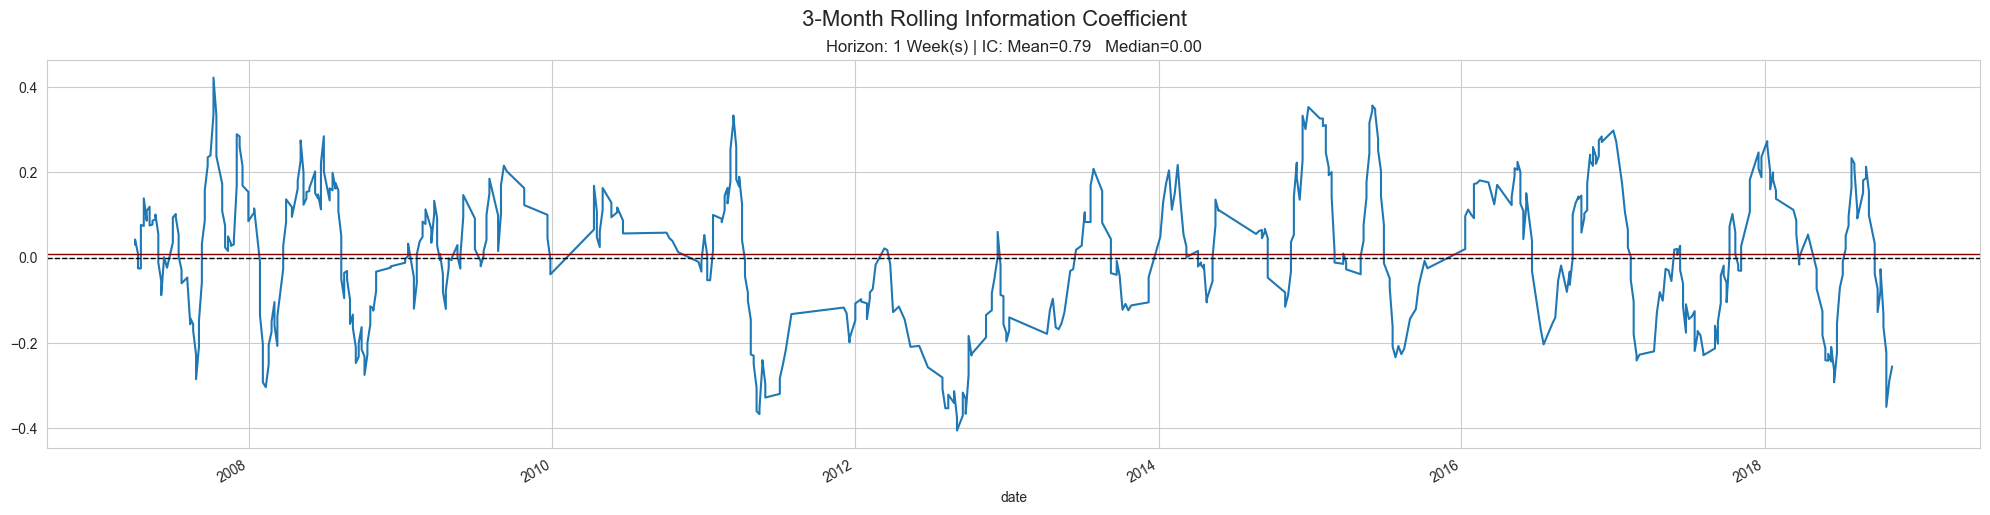

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
axes = [axes]
for i, t in enumerate([1]):
    params = get_rf_params(rf_daily_ic, t=t)
    data = select_ic(params, rf_ic, lookahead=t).sort_index()
    rolling = data.rolling(3 * 4).ic.mean().dropna()
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(
        ax=axes[i],
        title=f"Horizon: {t} Week(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}",
    )
    axes[i].axhline(avg, c="darkred", lw=1)
    axes[i].axhline(0, ls="--", c="k", lw=1)

fig.suptitle("3-Month Rolling Information Coefficient", fontsize=16, y=1.02)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [ ]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_rf_params(rf_daily_ic, t=lookahead, best=best)
    key = get_rf_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(
            results_path / "tuning_rf.h5", "predictions/" + key
        )
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(
            results_path / "tuning_rf.h5", "predictions/" + key
        )[rounds]
best_predictions = best_predictions.sort_index()

In [ ]:
key

'1/216/12/0.95/0.95/89/-1'

In [ ]:
best_predictions.to_hdf("data/predictions.h5", f"rf/train/{lookahead:02}")
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5616 entries, ('XLB', Timestamp('2007-01-21 00:00:00')) to ('XLY', Timestamp('2018-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5616 non-null   float64
 1   1       5616 non-null   float64
 2   2       5616 non-null   float64
 3   3       5616 non-null   float64
 4   4       5616 non-null   float64
 5   5       5616 non-null   float64
 6   6       5616 non-null   float64
 7   7       5616 non-null   float64
 8   8       5616 non-null   float64
 9   9       5616 non-null   float64
dtypes: float64(10)
memory usage: 498.7+ KB
